# CALCULATING PSEUDOTIME FOR HUMAN CELLS

In this notebook, we preprocess the human data using scanpy tools, and integrate the samples using ingest. We then calculate diffusion pseudotime, and prepare the metadata and data matrices for further downstream analyses in both python and R.

In [2]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from sklearn import preprocessing
import magic
import math
import rpy2
import bbknn
import anndata as ad
import scvelo as scv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn

from IPython.display import clear_output
import pickle
import os
import sys

import scanpy as sc
import scanpy.external as sce

from numpy import ones,vstack
from numpy.linalg import lstsq

In [4]:
#import cell cycle genes
cell_cycle_genes = [x.strip() for x in open('C:/Users/Ji Lab/Documents/JID manuscript/regev_lab_cell_cycle_genes.txt')]
s_genes = [x for x in cell_cycle_genes[:43]]
g2m_genes = [x for x in cell_cycle_genes[43:]]

In [3]:
#import data
hu_rna_raw = sc.read_h5ad("C:/Users/Ji Lab/Documents/JID Manuscript/kc_int_filt_RNA.h5ad")
hu_rna= hu_rna_raw.copy()

In [6]:
#convert cluster identities from numeric to character, for graphing purposes
hu_rna.obs['integrated_snn_res.0.4'] = hu_rna.obs['integrated_snn_res.0.4'].astype("string")

In [7]:
#filter out genes that are not expressed in at least 1 cell
sc.pp.filter_genes(hu_rna, min_cells=1)
#calculate qc_metrics
sc.pp.calculate_qc_metrics(hu_rna, inplace = True)

In [8]:
sc.pp.normalize_total(hu_rna)
sc.pp.log1p(hu_rna)

In [9]:
#calculate highly_variable_genes (NOT USED IN ANY ANALYSIS)
sc.pp.highly_variable_genes(hu_rna, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=5000)

In [10]:
#Score cell cycle
sc.tl.score_genes_cell_cycle(hu_rna, s_genes=[x for x in s_genes if x in hu_rna.var_names], 
                             g2m_genes=[x for x in g2m_genes if x in hu_rna.var_names], use_raw=False)

In [11]:
#regress out seurat measure of the total number of molecules detected within a cell, and S_score and G2M_score
sc.pp.regress_out(hu_rna, ['nCount_RNA','S_score', 'G2M_score'])

In [12]:
sc.pp.pca(hu_rna)
sc.pp.neighbors(hu_rna, n_pcs = 20, n_neighbors=25)
sc.tl.umap(hu_rna, spread = 1, min_dist = 0.5)

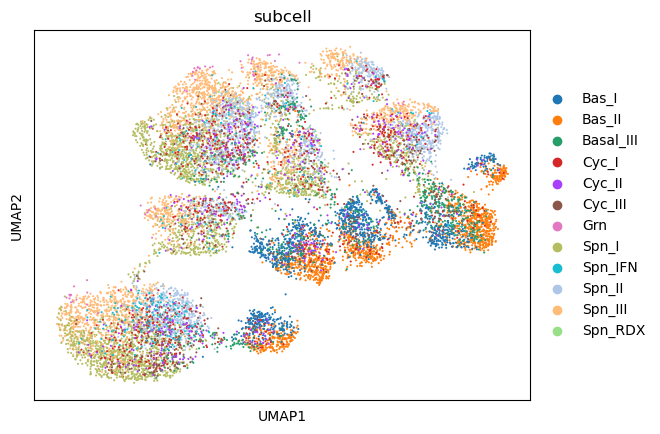

In [13]:
sc.pl.umap(hu_rna, color='subcell')

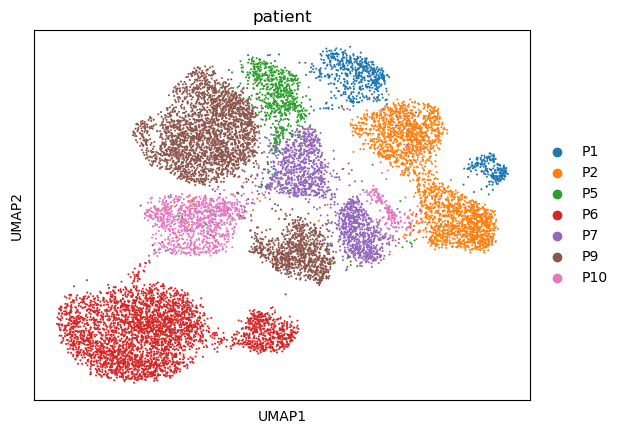

In [14]:
sc.pl.umap(hu_rna, color='patient')

## Integrating samples using ingest

As indicated in the above UMAP colored by "patient" identity, there are strong batch effects that need to be corrected through integration of the data. This was accomplished by using the pca-based integration method ingest within scanpy. 

For the human data, the sample "P6" was used as the reference data because it had the most cells.

In [15]:
hu_rna.obs.patient.value_counts()

P6     3506
P9     3427
P2     2273
P7     1613
P10    1138
P1      749
P5      710
Name: patient, dtype: int64

In [16]:
hu_rna_ref = hu_rna[hu_rna.obs['patient'] == 'P6']

In [17]:
sc.pp.pca(hu_rna_ref)
sc.pp.neighbors(hu_rna_ref)
sc.tl.umap(hu_rna_ref)

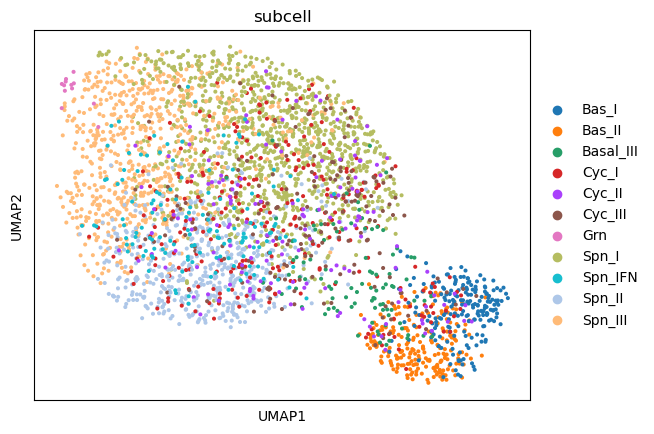

In [18]:
sc.pl.umap(hu_rna_ref, color='subcell')

In [19]:
adatas = [hu_rna[hu_rna.obs['patient'] == i].copy() for i in ['P1', 'P2', 'P5', 'P7', 'P9', 'P10']]

In [20]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['subcell_orig'] = adata.obs.subcell  # save the original cell type
    sc.tl.ingest(adata, hu_rna_ref, obs='subcell')

... integrating batch 1
running ingest
    finished (0:00:13)
... integrating batch 2
running ingest
    finished (0:00:09)
... integrating batch 3
running ingest
    finished (0:00:03)
... integrating batch 4
running ingest
    finished (0:00:07)
... integrating batch 5
running ingest
    finished (0:00:13)
... integrating batch 6
running ingest
    finished (0:00:05)


In [21]:
hu_rna_concat = hu_rna_ref.concatenate(adatas)

In [22]:
hu_rna_concat.obs.subcell = hu_rna_concat.obs.subcell.astype('category')
hu_rna_concat.obs.subcell.cat.reorder_categories(hu_rna_ref.obs.subcell.cat.categories, inplace=True)  # fix category ordering
hu_rna_concat.uns['subcell_colors'] = hu_rna_ref.uns['subcell_colors']  # fix category coloring

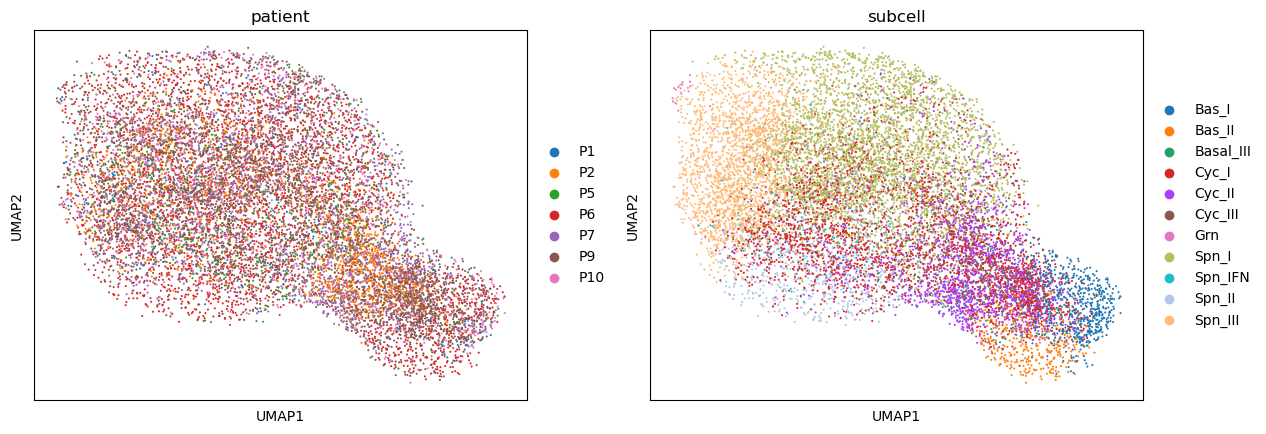

In [23]:
sc.pl.umap(hu_rna_concat, color=['patient', 'subcell'])

# Calculating diffusion pseudotime

Basal II was chosen as the root cluster for diffusion pseudotime. 

In [24]:
hu_rna_concat.uns['iroot'] = np.flatnonzero(hu_rna_concat.obs['subcell']  == 'Bas_II')[0]

In [25]:
sc.pp.neighbors(hu_rna_concat)
sc.tl.diffmap(hu_rna_concat)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98546    0.9437313  0.9305889  0.90642357 0.8983643
     0.8959924  0.88807946 0.87327814 0.86737823 0.86009496 0.8583253
     0.8535394  0.84642065 0.8421094 ]
    finished (0:00:00)


In [27]:
sc.tl.dpt(hu_rna_concat)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


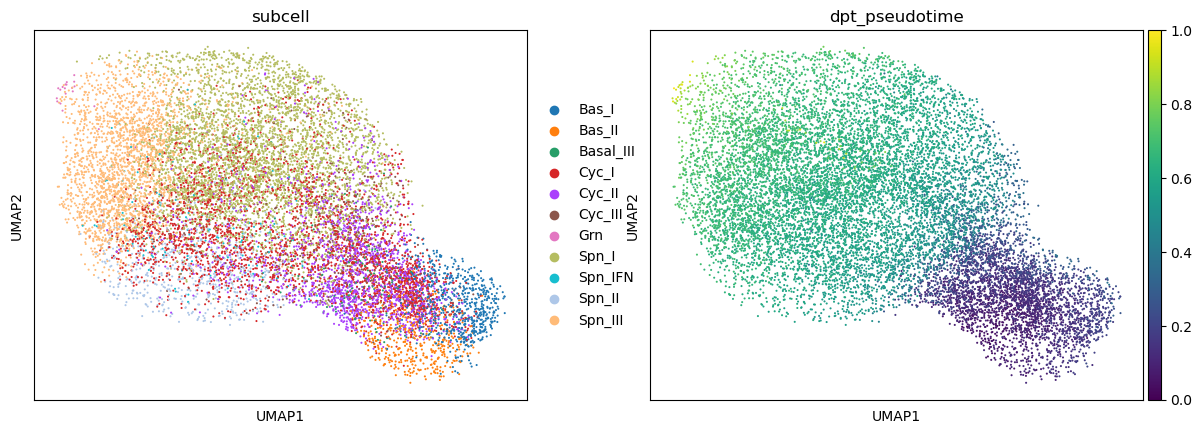

In [28]:
sc.pl.umap(hu_rna_concat, color = ['subcell','dpt_pseudotime'], ncols = 2, use_raw = False)

# Exporting anndata object

Due to issues with converting anndata objects into seurat objects, we separately exported the data matrix and metadata for manual reconstruction within R.

In [97]:
#renaming index (will not save h5ad correctly otherwise) 
hu_rna_concat.__dict__['_raw'].__dict__['_var'] = hu_rna_concat.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [98]:
#write to h5ad for analysis within python
hu_rna_concat.write("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag.h5ad")

In [99]:
#unused, metadata format not optimal
#hu_rna_concat.write_csvs("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag", skip_data=False)

In [100]:
#export scaled data matrix
pd.DataFrame(hu_rna_concat.X).to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag_X.csv")

In [101]:
#export raw count matrix
hu_rna_concat_raw_X_dense = pd.DataFrame(hu_rna_concat.raw.X.todense())
hu_rna_concat_raw_X_dense.to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag_raw_X.csv")

In [109]:
hu_rna_concat_raw_X_dense

,0,1,2,3,4,5,6,7,8,9,...,32728,32729,32730,32731,32732,32733,32734,32735,32736,32737
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13413,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13414,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
#export metadata
hu_rna_concat.obs.to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag_obs.csv")

In [103]:
#export var for subsetted gene names, to be used in creating seurat object
hu_rna_concat.var.to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag_var.csv")

In [104]:
#export raw var for variable names, to be used in creating seurat object
hu_rna_raw.var.to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_raw_ag_var.csv")

In [105]:
#export umap and pca embeddings 
pd.DataFrame(hu_rna_concat.obsm['X_umap']).to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag_umap.csv")
pd.DataFrame(hu_rna_concat.obsm['X_pca']).to_csv("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag_pca.csv")